# Exercise 5: Classical Monte Carlo simulation of a liquid–solid phase transition in a two-dimensional Lennard-Jones system

**Goal:** Simulate a system of $N=242$ Argon atoms in a 2D square box using the Metropolis Monte Carlo method. We aim to observe the liquid-solid phase transition by analyzing the energy and the radial distribution function $g(r)$ at various temperatures.

The particles interact via the Lennard-Jones potential:
$$U_{LJ}(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]$$
* It combines a repulsive hard core and an attractive tail.
* The repulsive hard core arises from the Pauli exclusion principle, which acts on fermions (electrons) not allowing them to stay in the same quantum state.
* The attractive long-range decay arises from the induced dipolar interaction.
* The characteristic range of the potential is proportional to $\sigma$ (position of the minimum is at $2^{1/6}\sigma$) and the characteristic energy (depth of the potential) is given by $\varepsilon$.

We work in reduced units where energy is measured in units of $\epsilon$ and distance in units of $\sigma$ (i.e., $\epsilon=1, \sigma=1$).The simulation is performed in the $(N, V, T)$ ensemble (constant number of particles, volume, and temperature).

**Method:**
1. We start by placing $N$ particles in the box.
2. Annealing Method: We start at high $T$ and cool down to find the ground state (crystalline) configuration.
3. Metropolis Algorithm: 
- Pick a particle $i$ and displace it randomly: $\vec{r}_i' = \vec{r}_i + \vec{\Delta}$.
- Calculate the energy change $\Delta E$.
- Accept move if $\Delta E < 0$ or with probability $e^{-\Delta E/T}$.
- Note: keep an acceptance rate of ~50%
6. Calculate radial distribution function $g(r)$ to distinguish liquid (short-range order) from solid (long-range order).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# ENERGY FUNCTIONS

@njit
def pbc_dist(dx, dy, L):
    """
    Apply periodic boundary conditions (PBC) to distance components.
    This allows us to eliminate surface effects and
    mimic a "bulk" infinite system using a small number of particles.

    Inputs: 
        dx, dy : distance difference between two particles
        L      : box length
    Outputs:
        distance : shortest physical distance between two particles
    """
    # Logi for PBC:
    # dx / L = what fraction of the box size is this distance dx?
    # np.round(dx / L) tells us that if the distance is more than half the box (0.5), 
    # it rounds up to 1, telling the code to "wrap around" to the other side
    # np.round(x) = np.floor(x + 0.5) 
    dx = dx - L * np.round(dx / L)
    dy = dy - L * np.round(dy / L)
    return np.sqrt(dx**2 + dy**2)

@njit
def potential_energy(x, y, N, L):
    """
    Computes potential energy of the system from scratch.

    Inputs:
        x, y : particle positions
        N    : number of particles
        L    : box length
    """
    E_total = 0.0
    for i in range(N-1):
        for j in range(i+1, N):
            r = pbc_dist(x[i] - x[j], y[i] - y[j], L)
            # Note: in a wrapping world, the farthest two particles can be apart is L/2 (half way across the box),
            # so interactions beyond that distance are ignored
            if r < L /2:    # cutoff convention (usually L/2 in MC)
                r6 = r**6
                r12 = r6**2
                E_total += 4.0 * (1.0 / r12 - 1.0 / r6)
    return E_total

@njit 
def delta_energy(x, y, i, dx_move, dy_move, N, L):
    """
    Computes the change in energy due to moving particle i by (dx_move, dy_move).
    """
    dE = 0.0
    x_old = x[i]
    y_old = y[i]
    x_new = x_old + dx_move
    y_new = y_old + dy_move

    for j in range(N):
        if i == j:
            continue    # particle does not interact with itself

        # Old interaction
        r_old = pbc_dist(x_old - x[j], y_old - y[j], L)
        if r_old < L/2:
            r6 = r_old**6
            r12 = r6**2
            E_old = 4.0 * (1.0/r12 - 1.0/r6)
        else:
            E_old = 0.0
            
        # New interaction
        r_new = pbc_dist(x_new - x[j], y_new - y[j], L)
        if r_new < L/2:
            r6 = r_new**6
            r12 = r6**2
            E_new = 4.0 * (1.0/r12 - 1.0/r6)
        else:
            E_new = 0.0
            
        dE += (E_new - E_old)
        
    return dE

# MC SIMULATION

@njit
def MC_simulation(x, y, N, L, T0, delta_max, n_steps, annealing=False):
    """
    Runs Monte Carlo simulation with Metropolis algorithm.
    If annealing is True, we slowly lower the temperature during the run.

    Inputs:
        x, y                : particle initial positions
        N                   : number of particles
        L                   : box length
        n_steps             : number of MC steps to perform
        T0                  : temperature
        delta_max           : maximum displacement for trial moves
        anneling            : True/False for simulated annealing
    Outputs:
        energies            : energy per particle history
        acceptance_history  : acceptance rate per step
        x, y                : final particle positions
    """
    # Initial energy
    current_energy = potential_energy(x, y, N, L)

    energies = np.zeros(n_steps)
    temps = np.zeros(n_steps)
    acceptance_history = np.zeros(n_steps)

    T = T0
    delta = delta_max

    # MC loop
    for step in range(n_steps):

        # 1. Anneling procedure
        if annealing:
            # exponential cooling
            T = 0.995 * T
            if T < 1e-5: T = 1e-5   # avoid zero temperature
            # shrink step size as T decreases to keep acceptance
            delta = delta_max * np.sqrt(T / T0)
        else:
            T = T0 # constant temperature
            delta = delta_max

        accepted_moves_in_step = 0

        # sweep over N particles (st each particle moves once)
        for k in range(N):
            # 2. Propose a random move to particle k only
            dx = delta * (2.0 * np.random.rand() - 1.0)
            dy = delta * (2.0 * np.random.rand() - 1.0)

            # 3. Compute energy difference
            dE = delta_energy(x, y, k, dx, dy, N, L)

            # 4. Metropolis algorithm: 
            # Accept move if energy is lower OR with probability exp(-dE/T)
            if dE < 0.0:
                accept = True
            else:
                if T > 1e-12: # Avoid division by zero for very low T
                    ratio = np.exp(- dE / T)
                    accept = np.random.rand() < ratio
                else:
                    accept = False
                
            if accept:
                # Update position
                x[k] += dx
                y[k] += dy
                # in case the particle is outside, put it back to the box (PBC)
                x[k] = x[k] - L * np.floor(x[k] / L)
                y[k] = y[k] - L * np.floor(y[k] / L)

                # Update energy
                current_energy += dE
                accepted_moves_in_step += 1
        
        # 5. Store data (once per step) 
        energies[step] = current_energy / N
        temps[step] = T
        acceptance_history[step] = accepted_moves_in_step / N

    return energies, temps, acceptance_history, x, y

def find_global_minimum(N, rho, n_repeats, n_steps, T0, delta_max):
    """
    Repeats the anneling process multiple times and returns the tuple (energies, temps, acc_rate, x, y)
    of the configuration with the lowest final energy.
    """
    # rho = N / L^2  =>  L = sqrt(N / rho)
    L = np.sqrt(N / rho)
    
    best_final_energy = np.inf # initial run always wins
    best_results = None 
    
    for i in range(n_repeats):
        # Initialize new lattice for this run
        # Note: the ceil of the scalar x is the smallest integer i, such that i >= x
        n_side = int(np.ceil(np.sqrt(N)))   # number of particles per side of the lattice
        x = np.zeros(N)
        y = np.zeros(N)
        idx = 0
        for r in range(n_side):     # rows
            for c in range(n_side): # columns
                if idx < N:         # if idx (particle index) is bigger than N (total number of particles), we stop
                    x[idx] = (r + 0.5) * (L / n_side)       # L / n_side is the spacing between particles
                    y[idx] = (c + 0.5) * (L / n_side)       # we add 0.5 to center particles in their cell
                    idx += 1
        
        # Run Annealing
        energies, temps, acc, x_final, y_final = MC_simulation(x, y, N, L, T0, delta_max, n_steps, annealing=True)
        
        final_E = energies[-1] # we check only final energy
        
        if final_E < best_final_energy:
            best_final_energy = final_E
            best_results = (energies, temps, acc, x_final, y_final)

    return best_results

We now run an annealing simulation for **argon** at density $\rho^* = 0.96$ in a square box of size $L \times L$ with $N=242$ particles. We want to obtain the particle configuration having the ground state energy (corresponding to a perfect crystal lattice).

C:\Users\jmarq\AppData\Local\Temp\ipykernel_8408\3833288334.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


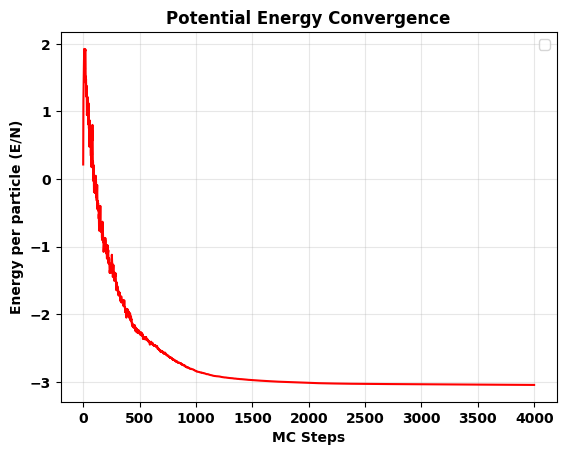

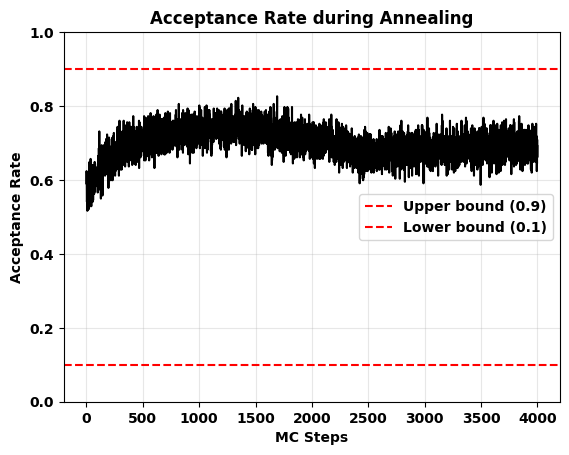

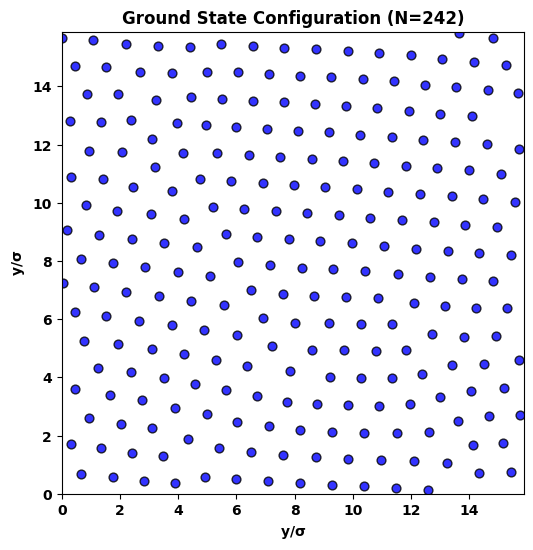

In [32]:
# PARAMETERS
N = 242
rho = 0.96
L = np.sqrt(N / rho)
n_repeats = 5
n_steps = 4000
T0 = 5.0
delta_max = 0.1

# SIMULATION
best_energies, best_temps, best_acc, best_x, best_y = find_global_minimum(
    N, rho, n_repeats, n_steps, T0, delta_max
    )

# PLOTTING

# Energy Convergence
plt.figure()
plt.plot(best_energies, c='red')
plt.xlabel('MC Steps')
plt.ylabel('Energy per particle (E/N)')
plt.title(f'Potential Energy Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Acceptance Rate
plt.figure()
plt.plot(best_acc, color='black')
plt.axhline(y=0.9, color='r', linestyle='--', label='Upper bound (0.9)')
plt.axhline(y=0.1, color='r', linestyle='--', label='Lower bound (0.1)')
plt.xlabel('MC Steps')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate during Annealing')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final Configuration (Ground State)
plt.figure(figsize=(6,6))
plt.scatter(best_x, best_y, s=40, c='blue', edgecolors='k', alpha=0.8)
plt.xlabel(r'$y/\sigma$')
plt.ylabel(r'$y/\sigma$')
plt.xlim(0, L)
plt.ylim(0, L)
plt.title(f'Ground State Configuration (N={N})')
plt.gca().set_aspect('equal')
plt.show()

We now compute the total energy per particle $E/N$, its standard deviation $\sigma_E$, and the radial distribution function $g(r)$. For a two dimensional system of area $S$ and density $\rho = N/S$, these are given by:

$$
\frac{E}{N} = \frac{2}{2} k_B T + \frac{1}{N} \left\langle \sum_{i=1}^{N} \sum_{j>i}^{N} U(r_{ij}) \right\rangle,
$$

$$
g(r) = \frac{1}{\rho} \frac{n(r, r + dr)}{2\pi r dr},
$$

where $n(r, r + dr)$ denotes the number of particles separated by distance larger than $r$ but smaller than $r + dr$.

The radial distribution function $g(r)$ represents the probability of finding a particle at a distance $r$ from another reference particle, normalized by the density of an ideal gas. It allows us to distinguish between the liquid and solid phases:
* Peaks: Indicate ordered shells (Solid).
* Flat: Indicates randomness (Liquid).


We repeat the simulation for the following temperatures: $T^*= 1.0$, $T^*=1.5$, $T^*=2.0$, $T^*=2.5$ and $T^*=3.0$.


List the technical parameters (the number of iterations, the displacement amplitude $\Delta$ and the acceptance rate) of all the simulations.


Plot the radial distribution functions $g(r)$ obtained for the different temperatures.

In [7]:
@njit
def compute_gr(x, y, N, L, n_bins):
    """
    Computes the Radial Distribution Function: g(r) = (1/rho) * (dn(r) / (2*pi*r*dr)) 

    Inputs:
        x, y    : particle positions
        N       : number of particles
        L       : box length
        n_bins  : number of bins for g(r) (resolution of the graph)
    
    """
    r_max = L / 2.0
    dr = r_max / n_bins
    
    gr_counts = np.zeros(n_bins)
    
    # Loop over unique pairs
    for i in range(N - 1):
        for j in range(i + 1, N):
            # Calculate PBC distance
            r = pbc_dist(x[i] - x[j], y[i] - y[j], L)
            
            if r < r_max:
                bin_idx = int(r / dr)   # index of the bin to which this distance belongs
                if bin_idx < n_bins:
                    if r > 1e-9:        # avoid division by zero
                        # Note: we add a factor of 2 to account for both (i,j) and (j,i)
                        gr_counts[bin_idx] += 2.0 / (2.0 * np.pi * r * dr) 

    # Final Normalization: g(r) = Sum(terms) / (N * rho)
    rho = N / (L**2)
    gr = gr_counts / (N * rho)
    
    # Generate r axis for plotting (bin centers)
    radii = np.linspace(dr/2, r_max - dr/2, n_bins)
    
    return radii, gr

T     | Steps  | Delta  | Acc(%)   | E_pot      | E_tot      | Sigma_E   
---------------------------------------------------------------------------
0.5   | 4000   | 0.10   | 33.5     | -2.7618    | -2.2618    | 0.0692    
1.0   | 4000   | 0.10   | 45.0     | -2.3793    | -1.3793    | 0.0584    
1.5   | 4000   | 0.10   | 50.3     | -1.9759    | -0.4759    | 0.0883    
2.0   | 4000   | 0.15   | 36.8     | -1.4627    | 0.5373     | 0.1286    
2.5   | 4000   | 0.15   | 39.0     | -0.9836    | 1.5164     | 0.1561    
3.0   | 4000   | 0.15   | 40.5     | -0.4807    | 2.5193     | 0.1662    
3.5   | 4000   | 0.15   | 42.2     | -0.0930    | 3.4070     | 0.1849    
4.0   | 4000   | 0.15   | 43.7     | 0.2170     | 4.2170     | 0.1984    
4.5   | 4000   | 0.15   | 45.0     | 0.5429     | 5.0429     | 0.2252    
5.0   | 4000   | 0.15   | 46.4     | 0.8261     | 5.8261     | 0.2384    


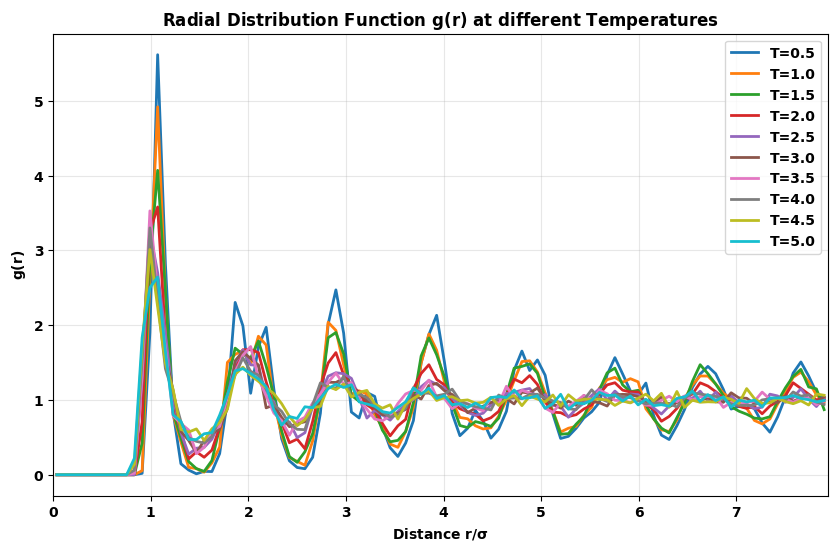

In [35]:
# PARAMETERS
temperatures = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

# Change this list to keep acceptance rate ~50%
delta_list = [0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15]

n_steps = 4000
rho = 0.96
N = 242
L = np.sqrt(N / rho)

results_E_mean = []
results_E_std = []
results_gr = []
results_r = None
results_acc = []

# We reuse the best configuration from anneling as the starting point
current_x = best_x.copy()
current_y = best_y.copy()

# We will save the final configurations at each temperature for later analysis
saved_configs = {}

print(f"{'T':<5} | {'Steps':<6} | {'Delta':<6} | {'Acc(%)':<8} | {'E_pot':<10} | {'E_tot':<10} | {'Sigma_E':<10}")
print("-" * 75)

# SIMULATION LOOP
for i, T in enumerate(temperatures):
    delta = delta_list[i]
    
    # 1. MC Simulation (with a fixed T, so Annealing=False)
    energies, temps, acc_hist, x_final, y_final = MC_simulation(
        current_x, current_y, N, L, T, delta, n_steps, annealing=False
    )
    
    # 2. Statistics 
    # Note: we discard the first 10% of values since they are not equilibrated (see Energy Evolution Figure above)
    valid_energies = energies
    
    E_pot_mean = np.mean(energies)
    E_pot_std = np.std(energies)
    
    # Total Energy in reduced units (E_tot = E_pot + T)
    E_tot_mean = E_pot_mean + T
    
    acc_rate = np.mean(acc_hist)
    
    # Store data
    results_E_mean.append(E_tot_mean)
    results_E_std.append(E_pot_std)
    results_acc.append(acc_rate)
    
    # 3. Compute g(r) using the final configuration
    r_axis, gr = compute_gr(x_final, y_final, N, L, n_bins=100)
    results_gr.append(gr)
    results_r = r_axis

    saved_configs[T] = (x_final.copy(), y_final.copy())
    
    current_x = x_final.copy()
    current_y = y_final.copy()
    
    print(f"{T:<5.1f} | {n_steps:<6} | {delta:<6.2f} | {acc_rate*100:<8.1f} | {E_pot_mean:<10.4f} | {E_tot_mean:<10.4f} | {E_pot_std:<10.4f}")

# g(r) Plot
plt.figure(figsize=(10, 6))

for i, T in enumerate(temperatures):
    plt.plot(results_r, results_gr[i], linewidth=2, label=f'T={T}')

plt.xlabel(r'Distance $r / \sigma$')
plt.ylabel(r'$g(r)$')
plt.title(r'Radial Distribution Function $g(r)$ at different Temperatures')
plt.legend()
plt.xlim(0, L/2)
plt.grid(True, alpha=0.3)
plt.show()


From the plot of $g(r)$, we can clearly distinguish two different phases:
* **Solid Phase (low $T$):** The graph shows sharp peaks oscillating at regular intervals, which indicates that atoms are locked in specific "shells" or layers relative to their neighbors -> long-range order -> perfect crystal.
* **Fluid Phase (high $T$):** The graph shows fewer and less sharp peaks, followed by a flat line at $g(r) \approx 1$, which indicates that beyond the nearest neighbors, the arrangement is "random" -> disordered fluid or gas.

We now plot the configurations ($x, y$ coordinates) for the lowest and the highest temperature to see the ordered lattice structure vs the disordered fluid state.

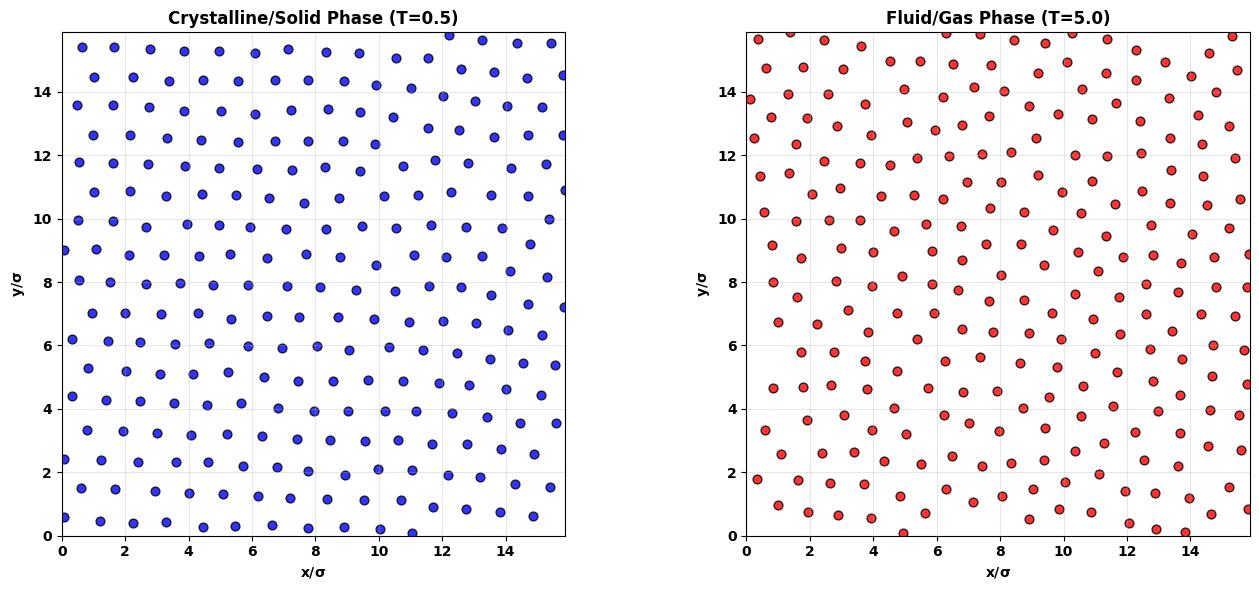

In [36]:
T_solid = temperatures[0]   # lowest temperature
T_fluid = temperatures[-1]  # highest temperature

x_solid, y_solid = saved_configs[T_solid]
x_fluid, y_fluid = saved_configs[T_fluid]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Crystalline Phase (Low T)
ax[0].scatter(x_solid, y_solid, s=40, c='blue', edgecolors='k', alpha=0.8)
ax[0].set_title(f'Crystalline/Solid Phase (T={T_solid})')
ax[0].set_xlim(0, L)
ax[0].set_ylim(0, L)
ax[0].set_aspect('equal')
ax[0].grid(True, alpha=0.3)
ax[0].set_xlabel(r'$x/\sigma$')
ax[0].set_ylabel(r'$y/\sigma$')

# Plot 2: Fluid Phase (High T)
ax[1].scatter(x_fluid, y_fluid, s=40, c='red', edgecolors='k', alpha=0.8)
ax[1].set_title(f'Fluid/Gas Phase (T={T_fluid})')
ax[1].set_xlim(0, L)
ax[1].set_ylim(0, L)
ax[1].set_aspect('equal')
ax[1].grid(True, alpha=0.3)
ax[1].set_xlabel(r'$x/\sigma$')
ax[1].set_ylabel(r'$y/\sigma$')

plt.tight_layout()
plt.show()